# Preprocessing of Causal MNIST - Playground

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import math
import os
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import CausalBarMNIST, CausalMNIST, MultiDistrDataModule
from gendis.model import NeuralClusteredASCMFlow
from gendis.noncausal.flows import (
    CouplingLayer,
    Dequantization,
    GatedConvNet,
    Reshape,
    UniformDequantization,
    VariationalDequantization,
    create_channel_mask,
    create_checkerboard_mask,
)
from gendis.noncausal.model import ImageFlow
from gendis.variational.vae import VAE

In [118]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=nrow, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(
        np.transpose(np_imgs, (1, 2, 0)),
        # interpolation="nearest"
    )
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [132]:
use_vardeq = False

flow_layers = []
n_flows = 8
if use_vardeq:
    vardeq_layers = [
        CouplingLayer(
            network=GatedConvNet(c_in=6, c_out=6, c_hidden=16),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=3,
        )
        for i in range(1)
    ]
    # flow_layers += vardeq_layers
    flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
else:
    flow_layers += [Dequantization()]

# flow_layers = [UniformDequantization(2)]

In [102]:
# get the images
graph_type = "chain"
root = "/Users/adam2392/pytorch_data/"


# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)


# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        # nf.utils.Jitter(1 / 256.0),  # apply random generation
        discretize,
        torchvision.transforms.RandomRotation(350),  # get random rotations
    ]
)

dataset = CausalBarMNIST(
    root=root,
    graph_type=graph_type,
    train=True,
    n_jobs=None,
    transform=transform,
)

img, metadata, targets = dataset[1]
print(img.shape)

torch.Size([3, 28, 28])


In [128]:
img, metadata, targets = dataset[100]
print(img.max(), img.min())
print(img.shape)

tensor(137, dtype=torch.int32) tensor(0, dtype=torch.int32)
torch.Size([3, 28, 28])


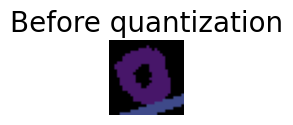



 33.06547619047619


<Axes: ylabel='Count'>

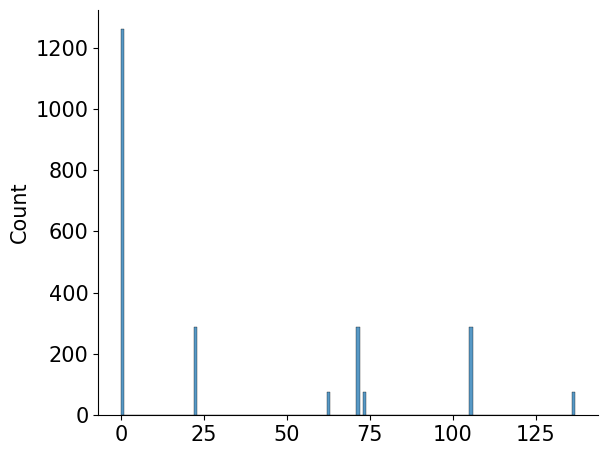

In [129]:
output = img.reshape(1, *img.shape)
show_imgs(img, title="Before quantization")
output = output.detach().numpy()
print("\n\n", output.mean())
sns.histplot(output.flatten(), binwidth=1)

Running:  <class 'gendis.noncausal.flows.Dequantization'> [torch.Size([3, 28, 28])]


 tensor(165.7668)
torch.Size([1, 3, 28, 28])
tensor(0.) tensor(255.)


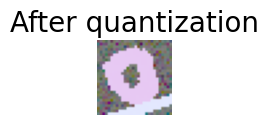

<Axes: ylabel='Count'>

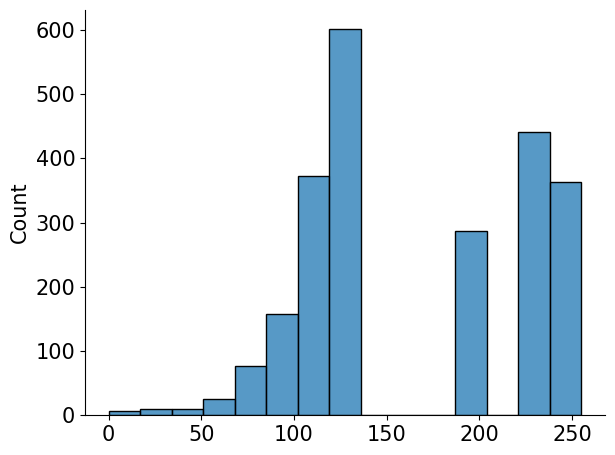

In [150]:
output = img.reshape(1, *img.shape)
ldj = 0
for flow in flow_layers:
    output, ldj = flow(output, ldj, reverse=False)
    print("Running: ", type(flow), [x.shape for x in output])

output = output - output.min()
output = output / output.max() * 255.0
# output = torch.Tensor(output.detach().numpy())#.astype(int))
print("\n\n", output.mean())
# output = output.to(torch.int)
print(output.shape)
print(output.min(), output.max())

# XXX: must be cast to int when plotting on a [0-255] scale
show_imgs(output.to(torch.int), title="After quantization")
# output = output.detach().numpy()
sns.histplot(output.flatten())

Running:  <class 'gendis.noncausal.flows.Dequantization'> [torch.Size([3, 28, 28])]
torch.Size([1, 3, 28, 28])
tensor(0, dtype=torch.int32) tensor(137, dtype=torch.int32)


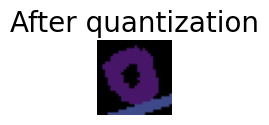

<Axes: ylabel='Count'>

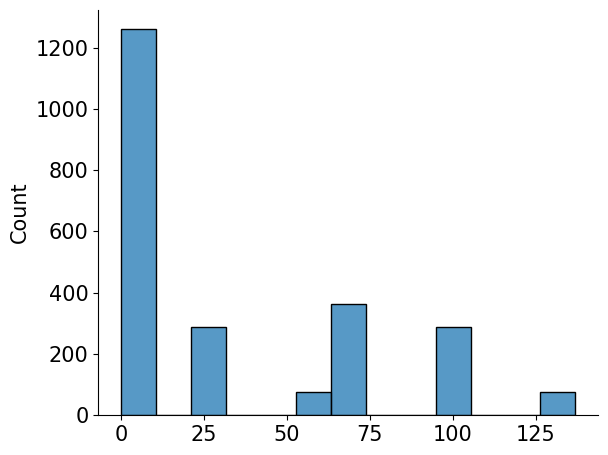

In [149]:
ldj = 0
for flow in flow_layers:
    output, ldj = flow(output, ldj, reverse=True)
    print("Running: ", type(flow), [x.shape for x in output])

# output = output - output.min()
# output = output / output.max() #* 255.
# output = output.to(torch.int)
output = output.detach()  # .numpy()
print(output.shape)
print(output.min(), output.max())
show_imgs(output, title="After quantization")
# output = output.detach().numpy()
sns.histplot(output.flatten())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Running:  <class 'gendis.noncausal.flows.Dequantization'> [torch.Size([3, 28, 28])]
tensor(0.2354) tensor(-12.0929)


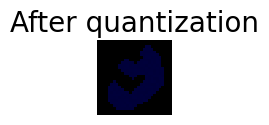

<Axes: ylabel='Count'>

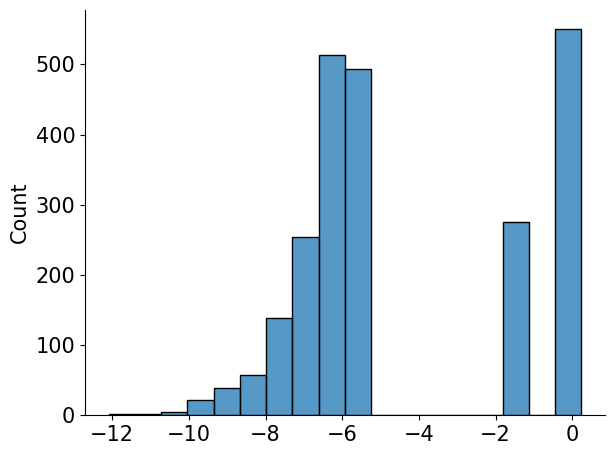

In [16]:
output = img.reshape(1, *img.shape)
ldj = 0
for flow in flow_layers:
    output, ldj = flow(output, ldj)
    print("Running: ", type(flow), [x.shape for x in output])

print(output.max(), output.min())

show_imgs(output, title="After quantization")
output = output.detach().numpy()
sns.histplot(output.flatten())

## Check quantization on regular MNIST images

In [47]:
# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        nf.utils.Jitter(1 / 256.0),  # apply random generation
        discretize,
    ]
)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(
    root="/Users/adam2392/pytorch_data/", train=True, transform=transform, download=True
)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

Global seed set to 42


In [48]:
use_vardeq = False

flow_layers = []
n_flows = 8
if use_vardeq:
    vardeq_layers = [
        CouplingLayer(
            network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=1,
        )
        for i in range(4)
    ]
    # flow_layers += vardeq_layers
    flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
else:
    flow_layers += [Dequantization()]

In [49]:
img = train_set[0][0]

print(img.shape)

torch.Size([1, 28, 28])


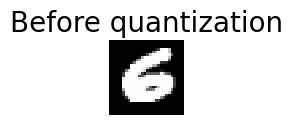

<Axes: ylabel='Count'>

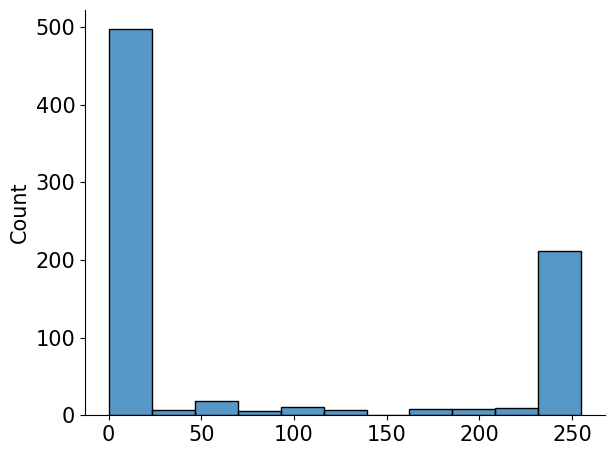

In [50]:
output = img.reshape(1, *img.shape)
show_imgs(output, title="Before quantization")
output = output.detach().numpy()
sns.histplot(output.flatten())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Running:  <class 'gendis.noncausal.flows.Dequantization'> [torch.Size([1, 28, 28])]
tensor(7.5941) tensor(-12.0368)


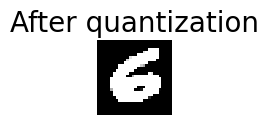

<Axes: ylabel='Count'>

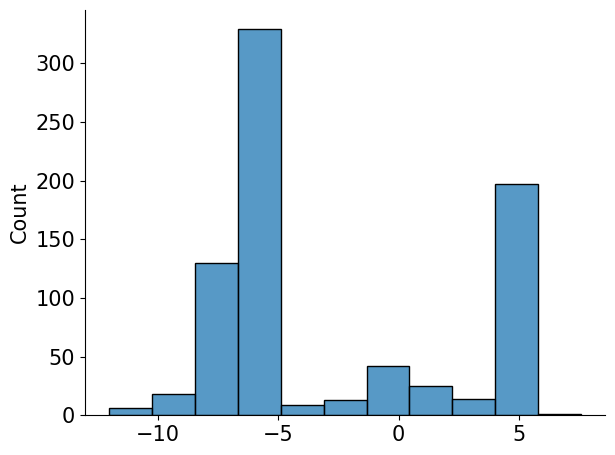

In [51]:
output = img.reshape(1, *img.shape)
ldj = 0
for flow in flow_layers:
    output, ldj = flow(output, ldj)
    print("Running: ", type(flow), [x.shape for x in output])

print(output.max(), output.min())

show_imgs(output, title="After quantization")
output = output.detach().numpy()
sns.histplot(output.flatten())